In [1]:
import gymnasium as gym
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np


env = gym.make("CartPole-v1")

is_ipython = "inline" in matplotlib.get_backend()

if is_ipython:
    from IPython import display


plt.ion()

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# tuple to store each state, action taken, future state based on this action and the reward for action taken
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
BATCH_SIZE = 128
GAMMA = 0.99  # weight of future rewards as compared to the immediate ones
EPS_START = 0.9  # initial promote exploration
EPS_END = 0.01  # later promote exploitation
EPS_DECAY = 2500
TAU = 0.005  # amount of detail from policy to target network to be copied per iteration
LR = 3e-4

n_actions = env.action_space.n  # type: ignore

state, info = env.reset()

n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)


target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()

    # calculate the actual epsilon value to use (based on the current decayed epsilon value)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(
        -1 * steps_done / EPS_DECAY
    )
    steps_done += 1

    # exploration or exploitation to use
    if sample > eps_threshold:
        with torch.no_grad():
            # exploitation
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        # exploration
        return torch.tensor(
            [[env.action_space.sample()]], device=device, dtype=torch.long
        )


episode_rewards = []
episode_durations = []
episode_losses = []
episode_qs = []
episode_epsilons = []


def plot_training_metrics(show_result=False):
    # Create a 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Rewards
    axs[0, 0].plot(episode_rewards, label="Total Reward", color="blue", alpha=0.6)
    if len(episode_rewards) >= 50:
        means = np.convolve(episode_rewards, np.ones(50) / 50, mode="valid")
        axs[0, 0].plot(
            range(49, len(episode_rewards)), means, color="red", label="50-Ep Avg"
        )
    axs[0, 0].set_title("Reward per Episode")
    axs[0, 0].set_ylabel("Total Reward")

    # 2. Loss
    axs[0, 1].plot(episode_losses, color="orange")
    axs[0, 1].set_title("Average Training Loss per Episode")
    axs[0, 1].set_ylabel("Loss")

    # 3. Epsilon
    axs[1, 0].plot(episode_epsilons, color="green")
    axs[1, 0].set_title("Epsilon Decay")
    axs[1, 0].set_ylabel("Epsilon")

    # 4. Average Q-Value
    axs[1, 1].plot(episode_qs, color="purple")
    axs[1, 1].set_title("Average Q-Value Estimation")
    axs[1, 1].set_ylabel("Q-Value")

    plt.tight_layout()

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

    # Close the figure to prevent memory leaks in loops
    plt.close()

In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return None, None

    # sampled values for experience to look up on
    transitions = memory.sample(BATCH_SIZE)

    # converting them to the right data type
    batch = Transition(*zip(*transitions))

    # extracting booleans telling if the current state had next state or not
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )

    # extracting the values that had next state, and not worrying about values that didn't
    # (since game over states would contribute towards learning process by saying nothing needs to be done, i.e "Zero next steps needed")
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        # programmatically populating the actual next state rewards by saying
        # if there was a next state -> predict the outcome based on current next state
        # if there wasn't a next state -> leave the value as Zero (since this is already generated by torch.zeros)
        next_state_values[non_final_mask] = (
            target_net(non_final_next_states).max(1).values
        )

    # provide the total reward generated based on weighing of current + future reward
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()

    # calculating loss between the two to update the policy network
    # DQN updates the policy network by estimating the loss it has, over itself (unstable for complex scenarios)
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    # Return loss and Q-values for plotting (as per previous updates)
    return loss.item(), state_action_values.mean().item()

Done


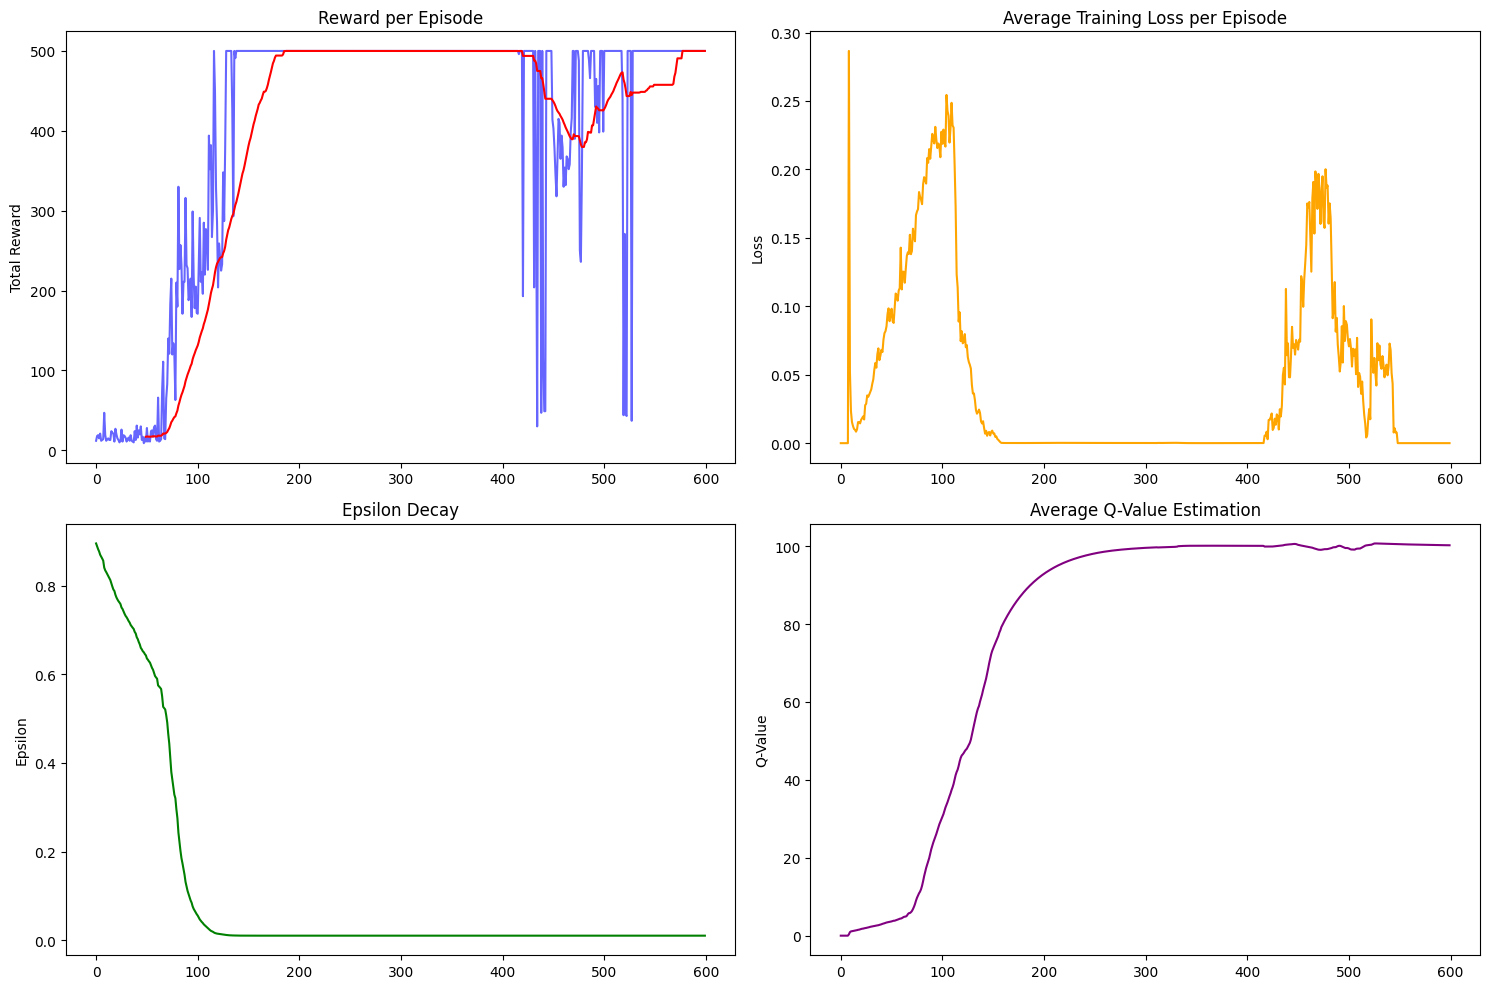

In [6]:
num_episodes = 600  # Or however many you want

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # Variables to track WITHIN the episode
    current_reward = 0
    temp_losses = []
    temp_qs = []

    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        # Track reward
        current_reward += reward

        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(
                observation, dtype=torch.float32, device=device
            ).unsqueeze(0)

        memory.push(state, action, next_state, reward)
        state = next_state

        # Capture returns from optimize_model
        loss_val, q_val = optimize_model()

        # Only append if optimization actually happened (i.e. not None)
        if loss_val is not None:
            temp_losses.append(loss_val)
            temp_qs.append(q_val)

        # Soft Update Target Net
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[
                key
            ] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # 1. Save Metrics
            episode_durations.append(t + 1)
            episode_rewards.append(current_reward)

            # Calculate average loss/Q for this episode
            avg_loss = np.mean(temp_losses) if temp_losses else 0
            avg_q = np.mean(temp_qs) if temp_qs else 0
            episode_losses.append(avg_loss)
            episode_qs.append(avg_q)

            # Calculate current Epsilon
            curr_eps = EPS_END + (EPS_START - EPS_END) * math.exp(
                -1 * steps_done / EPS_DECAY
            )
            episode_epsilons.append(curr_eps)

            # 2. Plot
            plot_training_metrics()
            break

print("Done")
plot_training_metrics(show_result=True)
plt.ioff()
plt.show()

In [7]:
torch.save(policy_net.state_dict(), "cartpole_pytorch_dqn_policy.pth")